In [1]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torchvision import datasets, models, transforms

# Para métricas
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score

# Verificar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [15]:
data_dir = '../data/'  # Ajusta esta ruta a tu dataset

# Tamaño de la imagen que usará el modelo pre-entrenado (por ejemplo, ResNet50 suele trabajar con 224x224)
input_size = 224

# Definimos transformaciones para train, validation y test
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # Convertir a 3 canales
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # Promedios ImageNet
                             [0.229, 0.224, 0.225])  # Desviaciones std ImageNet
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Cargamos los datasets
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        data_transforms[x]
    )
    for x in ['train', 'val', 'test']
}

# DataLoaders
batch_size = 128
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x],
        batch_size=batch_size,
        shuffle=True if x == 'train' else False,
        num_workers=2  # Ajusta según tu entorno
    )
    for x in ['train', 'val', 'test']
}

# Tamaño de cada conjunto de datos (para cómputo de epoch y métricas)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

# Clases
class_names = image_datasets['train'].classes
print("Clases encontradas:", class_names)


Clases encontradas: ['fractured', 'not fractured']


In [12]:
# Cargamos un modelo ResNet50 preentrenado en ImageNet
model = models.resnet50(weights="ResNet50_Weights.DEFAULT")

# Congelar parámetros (para no entrenar todo el modelo, sólo capas finales)
for param in model.parameters():
    param.requires_grad = False

# Modificamos la última capa (fc) para que tenga 2 salidas en lugar de 1000
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

# Definimos función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()

# Sólo entrenamos los parámetros de la última capa (fc)
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

# Podemos usar un scheduler para decrementar la LR en plateau o tras X epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Para guardar la evolución de las métricas
    history = {'train_loss': [], 'train_acc': [],
               'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Cada epoch tiene una fase de train y otra de val
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Modo entrenamiento
            else:
                model.eval()   # Modo evaluación

            running_loss = 0.0
            running_corrects = 0

            # Iteramos sobre los datos
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Poner gradientes a cero
                optimizer.zero_grad()

                # Forward
                # Track de gradientes solo en train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimizar solo en fase de train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Profundizar en la mejor red
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print(f'Training completo en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Mejor val Acc: {best_acc:4f}')

    # Cargamos los mejores pesos
    model.load_state_dict(best_model_wts)
    return model, history


In [14]:
num_epochs = 10
model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 0.6037 Acc: 0.6852
val Loss: 0.5465 Acc: 0.7618

Epoch 2/10
----------
train Loss: 0.5133 Acc: 0.7727
val Loss: 0.5183 Acc: 0.7509

Epoch 3/10
----------
train Loss: 0.4770 Acc: 0.7911
val Loss: 0.4975 Acc: 0.7497

Epoch 4/10
----------
train Loss: 0.4488 Acc: 0.8105
val Loss: 0.4419 Acc: 0.8323

Epoch 5/10
----------
train Loss: 0.4354 Acc: 0.8124
val Loss: 0.4327 Acc: 0.8348

Epoch 6/10
----------
train Loss: 0.4127 Acc: 0.8246
val Loss: 0.4432 Acc: 0.8056

Epoch 7/10
----------
train Loss: 0.4046 Acc: 0.8288
val Loss: 0.4098 Acc: 0.8481

Epoch 8/10
----------
train Loss: 0.4031 Acc: 0.8300
val Loss: 0.4256 Acc: 0.8202

Epoch 9/10
----------
train Loss: 0.3888 Acc: 0.8377
val Loss: 0.4153 Acc: 0.8323

Epoch 10/10
----------
train Loss: 0.3930 Acc: 0.8352
val Loss: 0.4190 Acc: 0.8287

Training completo en 6m 15s
Mejor val Acc: 0.848117


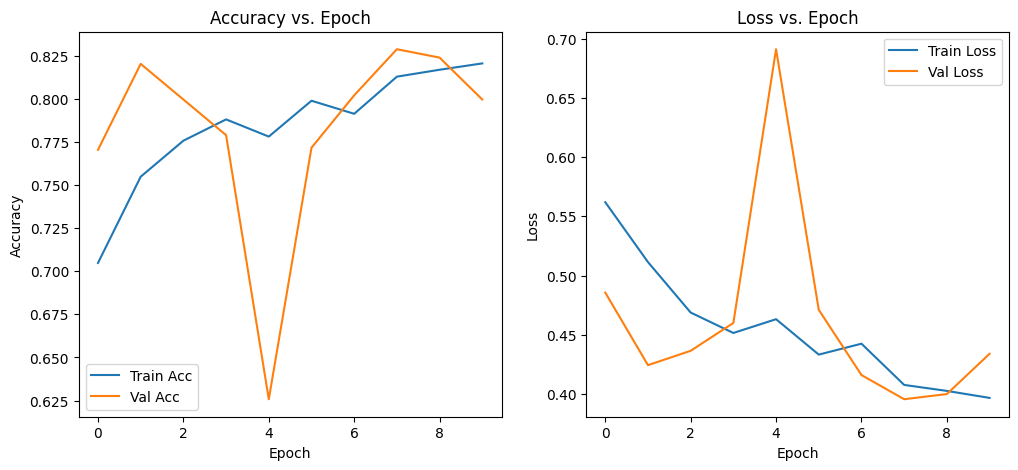

In [10]:
def plot_training_history(history):
    # Accuracy
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)


In [14]:
model.eval()  # Modo evaluación
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calcular métricas
acc = np.mean(all_preds == all_labels)
f1 = f1_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')

print("Resultados en Test Set:")
print(f"Accuracy:  {acc:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"Precision: {precision:.4f}")

# Reporte por clase
print("\nClassification Report (por clase):")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
print("Matriz de confusión:\n", cm)


Resultados en Test Set:
Accuracy:  0.8040
F1-score:  0.8040
Recall:    0.8040
Precision: 0.8041

Classification Report (por clase):
               precision    recall  f1-score   support

    fractured       0.79      0.80      0.79       238
not fractured       0.82      0.81      0.81       262

     accuracy                           0.80       500
    macro avg       0.80      0.80      0.80       500
 weighted avg       0.80      0.80      0.80       500

Matriz de confusión:
 [[190  48]
 [ 50 212]]


In [ ]:
torch.save(model.state_dict(), "best_model.pth")
